In [1]:
from binance.client import Client
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Binance API (⚠️ keep keys secret in real use)
api_key = "vBKombEymiA64O7LjsqEIACYJTsCrLojshIVjoMy9ibh63ePcTcaz6Ga5i229JzV"
api_secret = "r7LZZ37YlshUXdQoUkUoaMmsfIKAo1NT9esV7a2yWxcAZz5lp8it8txWvVVTBGdM"
client = Client(api_key, api_secret,testnet=True)

# Get 100 days of daily BTCUSDT data
candles = client.get_klines(symbol="BTCUSDT", interval=Client.KLINE_INTERVAL_1DAY, limit=103)



In [2]:
# Convert to DataFrame
df = pd.DataFrame(candles, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])
df = df[["timestamp", "open", "high", "low", "close", "volume"]]
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df["close"] = df["close"].astype(float)

# Train-test split index
split = int(len(df) * 0.8)

# Scale ONLY on training set to avoid leakage
scaler = MinMaxScaler()
scaler.fit(df[["close"]].iloc[:split])
df["close_scaled"] = scaler.transform(df[["close"]])

# Create lag features + technical features
df["lag1"] = df["close_scaled"].shift(1)
df["lag2"] = df["close_scaled"].shift(2)
df["lag3"] = df["close_scaled"].shift(3)
df["return"] = df["close"].pct_change()
df["rolling_mean_3"] = df["close_scaled"].rolling(3).mean()

# Drop NaN rows caused by shifting/rolling
df = df.dropna().reset_index(drop=True)



In [3]:
# Features and target
X = df[["lag1", "lag2", "lag3", "return", "rolling_mean_3"]].values
y = df["close_scaled"].values
dates = df["timestamp"].values

# Train-test split again after feature creation
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train, dates_test = dates[:split], dates[split:]



## XGBoost Model

In [4]:
# Train XGBoost
model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_rescaled, y_pred)
mse = mean_squared_error(y_test_rescaled, y_pred)
print("MAE:", mae, "MSE:", mse)



MAE: 1292.481828124998 MSE: 2935101.056384345


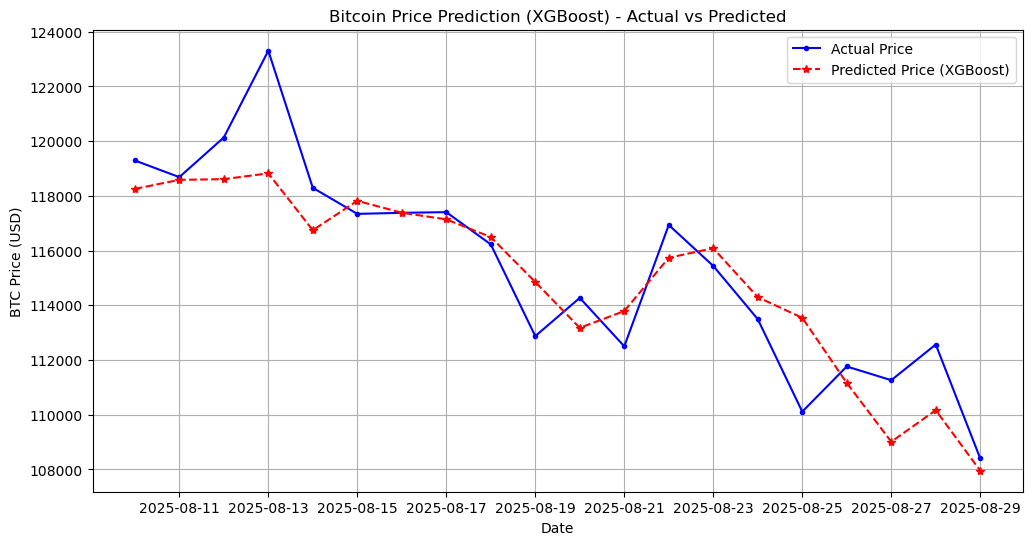

In [5]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_rescaled, label="Actual Price", color="blue", marker =".")
plt.plot(dates_test, y_pred, label="Predicted Price (XGBoost)", color="red", linestyle="--", marker="*")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.title("Bitcoin Price Prediction (XGBoost) - Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


#### Prediction of next day 

In [6]:
import numpy as np

# --- Step 1: get the last row of features
last_row = df.iloc[-1]

# Features must match training features order
X_next = np.array([[
    last_row["lag1"],
    last_row["lag2"],
    last_row["lag3"],
    last_row["return"],
    last_row["rolling_mean_3"]
]])

# --- Step 2: predict (still in scaled form)
y_next_scaled = model.predict(X_next)

# --- Step 3: inverse transform back to real BTC price
y_next = scaler.inverse_transform(y_next_scaled.reshape(-1, 1)).ravel()[0]

print(f"Predicted next day BTC price: ${y_next:,.2f}")


Predicted next day BTC price: $107,952.81


## Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [8]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print('Done')

Done


In [9]:
MAE = mean_absolute_error(y_test_rescaled, y_pred)
MAE

1292.481828124998

In [10]:
mse = mean_squared_error(y_test_rescaled, y_pred)
mse

2935101.056384345

In [11]:
y_test_rescaled.shape

(20,)

In [12]:
y_pred.shape

(20,)

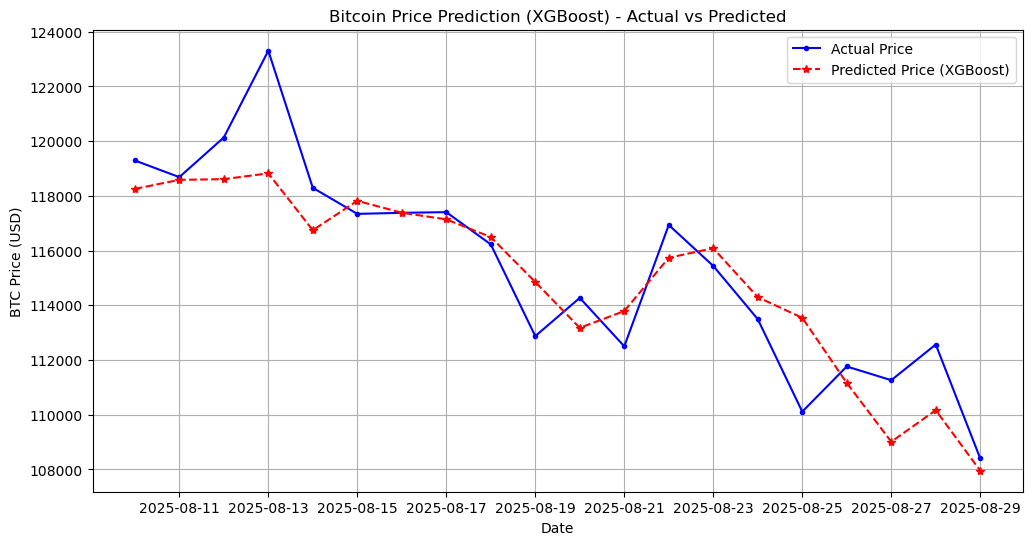

In [13]:
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_rescaled, label="Actual Price", color="blue", marker =".")
plt.plot(dates_test, y_pred, label="Predicted Price (XGBoost)", color="red", linestyle="--", marker="*")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.title("Bitcoin Price Prediction (XGBoost) - Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print('LR score',lr_model.score(X_test,y_test))

LR score 1.0


## Real time

In [15]:
from binance.client import Client
import os

# Create a client (you can create an API key in Binance account)
api_key = "zZAJfb9fnVSD56Z6WWavnm1tcsYucAmcFYRk4LSX3Z0Cai2Wlqt31C9Kyv3JTG0y"
api_secret = "Z86f6sjcJpUxCwgKijcjkL1Tm9uZXh8myubOER1eqFtdqVCdLZbxt1gIs0T1onKc"
client = Client(api_key, api_secret)

# Get latest BTC/USDT price
price = client.get_symbol_ticker(symbol="BTCUSDT")
print(f"BTC Price: {price} USD")


BTC Price: {'symbol': 'BTCUSDT', 'price': '108400.01000000'} USD


In [16]:
type(price)

dict

In [17]:
df.shape

(100, 12)

In [18]:
df.head()

,timestamp,open,high,low,close,volume,close_scaled,lag1,lag2,lag3,return,rolling_mean_3
0,2025-05-22,109643.99000000,111980.00000000,109177.37000000,111696.21,31630.77313000,0.565141,0.457076,0.309950,0.242745,0.018717,0.444056
1,2025-05-23,111696.22000000,111800.00000000,106800.00000000,107318.30,31737.72309000,0.334610,0.565141,0.457076,0.309950,-0.039195,0.452276
2,2025-05-24,107318.30000000,109506.03000000,106875.41000000,107761.91,16782.53129000,0.357970,0.334610,0.565141,0.457076,0.004134,0.419240
3,2025-05-25,107761.90000000,109299.99000000,106600.64000000,109004.19,17710.04695000,0.423385,0.357970,0.334610,0.565141,0.011528,0.371988
4,2025-05-26,109004.20000000,110422.22000000,108670.58000000,109434.79,14649.11593000,0.446060,0.423385,0.357970,0.334610,0.003950,0.409138


In [19]:
df.tail()

,timestamp,open,high,low,close,volume,close_scaled,lag1,lag2,lag3,return,rolling_mean_3
95,2025-08-25,113493.59000000,113667.28000000,109274.10000000,110111.98,25182.79379000,0.481719,0.659787,0.762178,0.841056,-0.029796,0.634561
96,2025-08-26,110111.98000000,112371.00000000,108666.66000000,111763.22,18452.43877000,0.568670,0.481719,0.659787,0.762178,0.014996,0.570059
97,2025-08-27,111763.22000000,112625.00000000,110345.42000000,111262.01,13392.60875000,0.542277,0.568670,0.481719,0.659787,-0.004485,0.530889
98,2025-08-28,111262.01000000,113485.90000000,110862.42000000,112566.90,11104.27744000,0.610990,0.542277,0.568670,0.481719,0.011728,0.573979
99,2025-08-29,112566.90000000,112638.64000000,108103.00000000,108400.00,17996.75186000,0.391570,0.610990,0.542277,0.568670,-0.037017,0.514946


In [20]:
print(type(float(price['price'])))

<class 'float'>


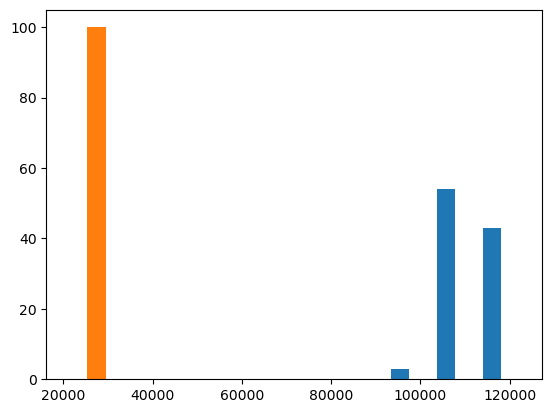

In [21]:
plt.hist([df['close'],df['timestamp']])
# plt.legend()
plt.show()
         